In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import *

import utils
from model.loss import *
from diffusion_dist import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import phate
import umap 

In [2]:
rna_dataset = hhRNA(standardize=False, rna_seq_file = "./data/human_hematopoiesis/count_rna.csv", rna_celltype_file = "./data/human_hematopoiesis/celltypes_rna.txt", anchor = "MEP")
atac_dataset = hhATAC(standardize=False, atac_seq_file = "./data/human_hematopoiesis/count_atac.csv", atac_celltype_file = "./data/human_hematopoiesis/celltypes_atac.txt", anchor = "MEP")

rna_CONFIG = { 
    'in_features': 500,
    'layers': [512, 256, 64, 8], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

atac_CONFIG = { 
    'in_features': 1764,
    'layers': [512, 256, 64, 8], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}


train_rna_loader = DataLoader(rna_dataset, batch_size = rna_CONFIG["minibatch_size"], shuffle = True)
train_atac_loader = DataLoader(atac_dataset, batch_size = atac_CONFIG["minibatch_size"], shuffle = True)
test_rna_loader = DataLoader(rna_dataset, batch_size = len(rna_dataset), shuffle = False)
test_atac_loader = DataLoader(atac_dataset, batch_size = len(atac_dataset), shuffle = False)

for data in test_rna_loader:
    U_t1, Diff1 = phate_similarity(data["raw"], 
                                  # control radius with decay
                                  n_neigh = 5, 
                                  t = 8, 
                                  use_potential = True, 
                                  # control radius with decay, if thresh equals to 0, the decaying of the kernel function is still calculated adaptively, with the equation np.exp(-1 * np.power(pdx, self.decay)) and pdx = (pdx.T / dist_kth).T
                                  thresh = 0,
                                  # decay gets larger, the radius get smaller, when decay gets infinity, the radius equals to the exact kth neighbor distance: radius = dist_kth * np.power(-1 * np.log(thresh),1/decay), the node outside the distance will be not connected
                                  # decay gets smaller, can be efficient
                                  decay = 40)

    
    Diff1 = torch.FloatTensor(Diff1).to(device)
    U_t1 = torch.FloatTensor(U_t1).to(device)
    # X_umap1 = umap.UMAP(n_components=2).fit_transform(data["raw"].numpy())
    # X_tsne1 = TSNE(n_components = 2).fit_transform(data["raw"].numpy())
    # X_phate1 = phate.PHATE(n_components=2).fit_transform(data["raw"].numpy())


    

for data in test_atac_loader:
    U_t2, Diff2 = phate_similarity(data["raw"], 
                                  n_neigh = 5, 
                                  t = 20, 
                                  use_potential = True,
                                  thresh = 0,
                                  decay = 10)


      
    
    Diff2 = torch.FloatTensor(Diff2).to(device)
    U_t2 = torch.FloatTensor(U_t2).to(device)
    # X_umap2 = umap.UMAP(n_components=2).fit_transform(data["raw"].numpy())
    # X_tsne2 = TSNE(n_components = 2).fit_transform(data["raw"].numpy())
    # X_phate2 = phate.PHATE(n_components=2).fit_transform(data["raw"].numpy())

In [3]:
# plot_latent(z1 = X_umap1, z2 = X_umap2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "separate",save = None)

In [4]:
# plot_latent(z1 = X_tsne1, z2 = X_tsne2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "separate",save = None)

In [5]:
# plot_latent(z1 = X_phate1, z2 = X_phate2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "separate",save = None)

In [6]:
encoder1 = ae.Encoder(rna_CONFIG).to(device)
encoder2 = ae.Encoder(atac_CONFIG).to(device)
fusion = ae.Fusion(in_channels = rna_CONFIG['layers'][-1], hidden_channels = 4, embed_channels = 2, use_hidden = True)
decoder1 = ae.Decoder(rna_CONFIG)
decoder2 = ae.Decoder(atac_CONFIG)


optimizer_rna = torch.optim.Adam(list(encoder1.parameters()) + list(decoder1.parameters()), lr = 5e-4)
optimizer_atac = torch.optim.Adam(list(encoder2.parameters()) + list(decoder2.parameters()), lr = 5e-4)
optimizer_dist_rna = torch.optim.Adam(list(encoder1.parameters()) + list(fusion.parameters()), lr = 5e-4)
optimizer_dist_atac = torch.optim.Adam(list(encoder2.parameters()) + list(fusion.parameters()), lr = 5e-4)

In [7]:
disc = ae.discriminator(infeatures = rna_CONFIG['layers'][-1], hidden1 = 64, hidden2 = 32, hidden3 = 1).to(device)
optimizer_D = torch.optim.Adam(disc.parameters(), lr = 1e-3)

In [8]:
utils.pretrain_embedding(encoder1 = encoder1, encoder2 = encoder2, fusion = fusion, decoder1 = decoder1, decoder2 = decoder2, data_loader1 = train_rna_loader, data_loader2 = train_atac_loader, diff_sim1 = Diff1, diff_sim2 = Diff2, recon_opt1 = optimizer_rna, recon_opt2 = optimizer_atac, dist_opt1 = optimizer_dist_rna, dist_opt2 = optimizer_dist_atac, n_epochs = 101, lamb_r1 = 1, lamb_r2 = 1, dist_mode = "mse")

epoch:  0 RNA recon loss: 0.59602, RNA dist loss: 0.41004 ATAC recon loss: 3.12259, ATAC dist loss: 0.37400
epoch:  10 RNA recon loss: 0.08848, RNA dist loss: 0.15796 ATAC recon loss: 0.07213, ATAC dist loss: 0.10006
epoch:  20 RNA recon loss: 0.07334, RNA dist loss: 0.12484 ATAC recon loss: 0.03694, ATAC dist loss: 0.09265
epoch:  30 RNA recon loss: 0.06348, RNA dist loss: 0.10753 ATAC recon loss: 0.02313, ATAC dist loss: 0.06554
epoch:  40 RNA recon loss: 0.06697, RNA dist loss: 0.09403 ATAC recon loss: 0.01827, ATAC dist loss: 0.03841
epoch:  50 RNA recon loss: 0.05799, RNA dist loss: 0.10664 ATAC recon loss: 0.01553, ATAC dist loss: 0.04330
epoch:  60 RNA recon loss: 0.05224, RNA dist loss: 0.08307 ATAC recon loss: 0.01892, ATAC dist loss: 0.10119
epoch:  70 RNA recon loss: 0.05220, RNA dist loss: 0.09223 ATAC recon loss: 0.01165, ATAC dist loss: 0.05429
epoch:  80 RNA recon loss: 0.05009, RNA dist loss: 0.09930 ATAC recon loss: 0.01188, ATAC dist loss: 0.04029
epoch:  90 RNA recon

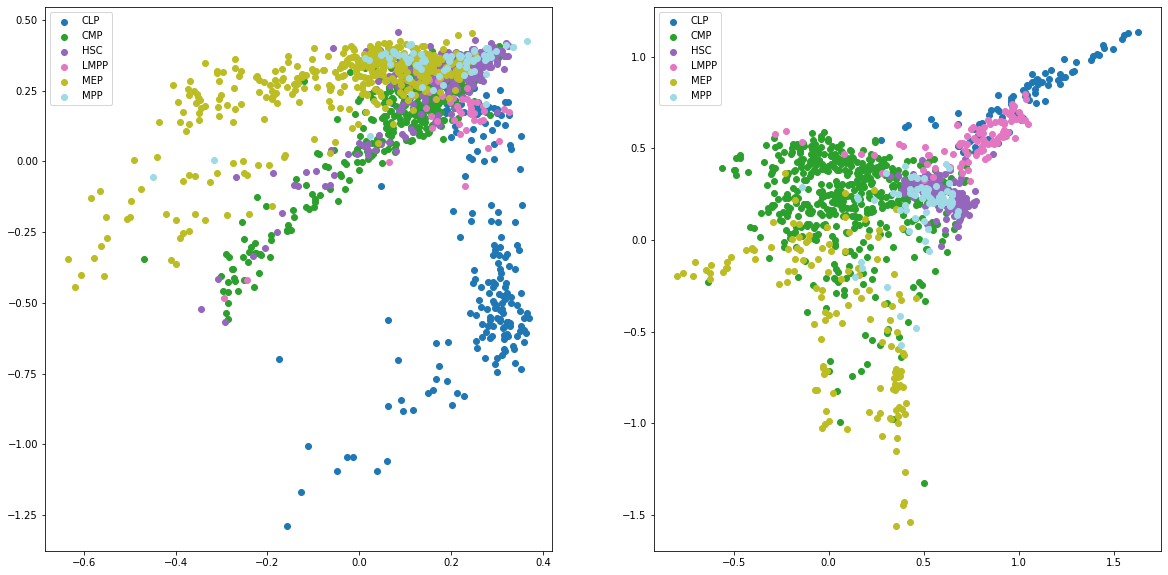

In [9]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = fusion(encoder1(data['count'].to(device))).cpu().detach().numpy()

    for data in test_atac_loader:
        ae_coordinates2 = fusion(encoder2(data['count'].to(device))).cpu().detach().numpy()

    plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = None)

In [10]:
utils.pre_train_disc(encoder1 = encoder1, encoder2 = encoder2, disc = disc, data_loader1 = train_rna_loader, data_loader2 = train_atac_loader, disc_opt = optimizer_D, n_epochs = 201, use_anchor = True)

epoch:  0 Discriminator loss: 0.68357
epoch:  10 Discriminator loss: 0.50882
epoch:  20 Discriminator loss: 0.24098
epoch:  30 Discriminator loss: 0.12193
epoch:  40 Discriminator loss: 0.04880
epoch:  50 Discriminator loss: 0.06835
epoch:  60 Discriminator loss: 0.02821
epoch:  70 Discriminator loss: 0.02079
epoch:  80 Discriminator loss: 0.01910
epoch:  90 Discriminator loss: 0.01216
epoch:  100 Discriminator loss: 0.02928
epoch:  110 Discriminator loss: 0.02338
epoch:  120 Discriminator loss: 0.02321
epoch:  130 Discriminator loss: 0.01249
epoch:  140 Discriminator loss: 0.01348
epoch:  150 Discriminator loss: 0.01418
epoch:  160 Discriminator loss: 0.00806
epoch:  170 Discriminator loss: 0.00543
epoch:  180 Discriminator loss: 0.00091
epoch:  190 Discriminator loss: 0.00595
epoch:  200 Discriminator loss: 0.00100


In [11]:
# n_iter = 200 merge too good
utils.train_unpaired(encoder1 = encoder1, encoder2 = encoder2, decoder1 = decoder1, decoder2 = decoder2, fusion = fusion, disc = disc, data_loader1 = train_rna_loader, data_loader2 = train_atac_loader, diff_sim1 = Diff1, diff_sim2 = Diff2, recon_opt1 = optimizer_rna, recon_opt2 = optimizer_atac, dist_opt1 = optimizer_dist_rna, dist_opt2 = optimizer_dist_atac, disc_opt = optimizer_D, n_epochs=201, n_iter=150, n_iter2 = 2, lamb_r1 = 1, lamb_r2 = 1, lamb_disc=1, dist_mode = "mse", use_anchor = True)

epoch:  0 RNA recon loss: 0.06163, RNA dist loss: 0.10229 ATAC recon loss: 0.00937, ATAC dist loss: 0.04894 Discriminator loss: 0.00712
epoch:  10 RNA recon loss: 0.06350, RNA dist loss: 0.24766 ATAC recon loss: 0.01620, ATAC dist loss: 0.21741 Discriminator loss: 0.18639
epoch:  20 RNA recon loss: 0.06221, RNA dist loss: 0.19328 ATAC recon loss: 0.01228, ATAC dist loss: 0.17566 Discriminator loss: 0.18473
epoch:  30 RNA recon loss: 0.05779, RNA dist loss: 0.22272 ATAC recon loss: 0.01252, ATAC dist loss: 0.17896 Discriminator loss: 0.30831
epoch:  40 RNA recon loss: 0.06056, RNA dist loss: 0.25080 ATAC recon loss: 0.01010, ATAC dist loss: 0.20922 Discriminator loss: 0.43019
epoch:  50 RNA recon loss: 0.05468, RNA dist loss: 0.23930 ATAC recon loss: 0.00869, ATAC dist loss: 0.19070 Discriminator loss: 0.40512
epoch:  60 RNA recon loss: 0.05306, RNA dist loss: 0.17754 ATAC recon loss: 0.00958, ATAC dist loss: 0.16510 Discriminator loss: 0.38301
epoch:  70 RNA recon loss: 0.05380, RNA di

In [13]:
# torch.save({
#     'encoder1': encoder1.state_dict(),
#     'encoder2': encoder2.state_dict(),
#     'disc': disc.state_dict(),
#     'fusion': fusion.state_dict(),
#     'decoder1': decoder1.state_dict(),
#     'decoder2': decoder2.state_dict(),
#     'config1': rna_CONFIG,
#     'config2': atac_CONFIG,
#     'Diff1': Diff1,
#     'Diff2': Diff2
# }, './saved_model/endo_phate_new_withIAC3_pretrain_2latent.pt')

In [14]:
# state = torch.load('./saved_model/endo_phate_new_withIAC3_pretrain_2latent.pt')

# encoder1 = ae.Encoder(rna_CONFIG).to(device)
# encoder1.load_state_dict(state['encoder1'])

# encoder2 = ae.Encoder(atac_CONFIG).to(device)
# encoder2.load_state_dict(state['encoder2'])

# fusion = ae.Fusion(in_channels = rna_CONFIG['layers'][-1], hidden_channels = 2, embed_channels = 2, activation = False, use_hidden = False)
# fusion.load_state_dict(state['fusion'])

# decoder1 = ae.Decoder(rna_CONFIG).to(device)
# decoder1.load_state_dict(state['decoder1'])

# decoder2 = ae.Decoder(atac_CONFIG).to(device)
# decoder2.load_state_dict(state['decoder2'])

# disc = ae.discriminator(infeatures = rna_CONFIG['layers'][-1], hidden1 = 64, hidden2 = 32, hidden3 = 1).to(device)
# disc.load_state_dict(state['disc'])

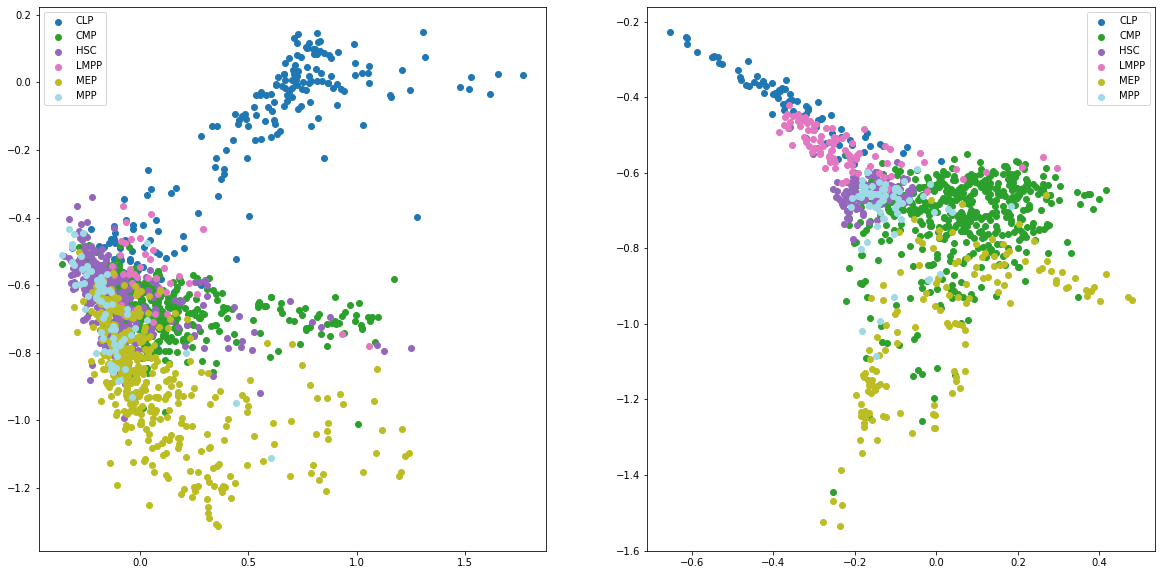

In [16]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = fusion(encoder1(data['count'].to(device))).cpu().detach().numpy()

    for data in test_atac_loader:
        ae_coordinates2 = fusion(encoder2(data['count'].to(device))).cpu().detach().numpy()

    plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = None)

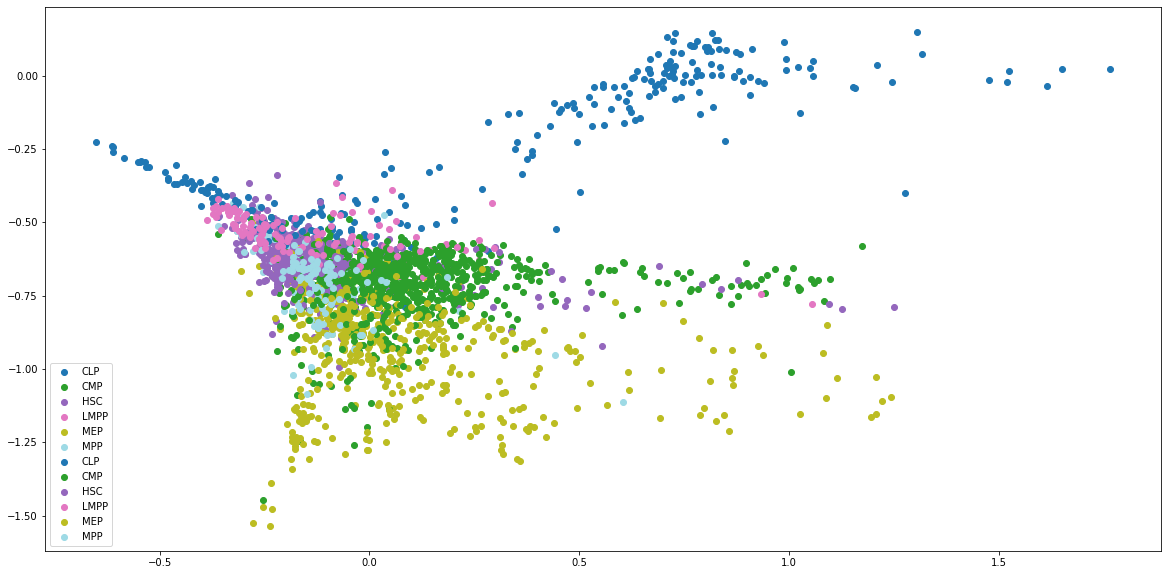

In [17]:
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "joint",save = None)

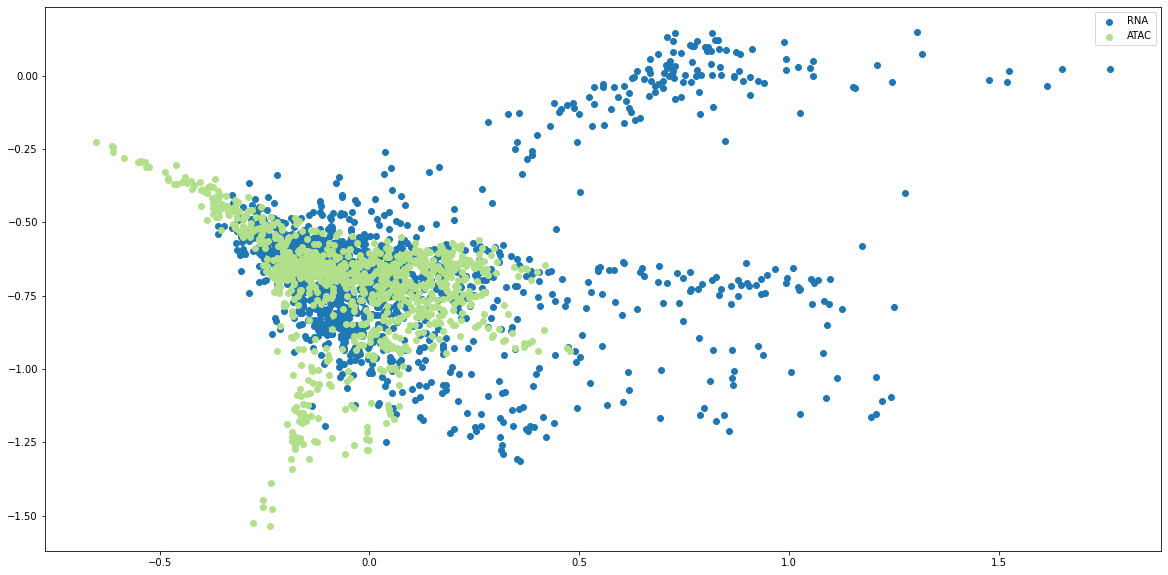

In [18]:
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "modality",save = None)